In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join('..')))

from models import gptv1

config = gptv1.GPTv1Config(device="mps", batch_size=16, block_size=256, n_heads=6)
device = config.device

In [2]:
filepath = "../../data/freud/interpretation-of-dreams.txt"
input_file = open(filepath, 'r', encoding='utf-8')
raw_text = input_file.read()
input_file.close()

In [ ]:
from utilities import text_cleaning
from utilities import tokenizer2 as tokenizer
text = text_cleaning.basic_cleaning(raw_text)
td = tokenizer.create_tokenizer(text, num_tokens=128)
print(td)
print(len(td.token_set))

TokenDictionary(token_set=['\n', ' ', '!', '&', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '·', 'À', 'Â', 'Æ', 'É', 'Ü', 'à', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ó', 'ô', 'û', 'ü', 'Œ', 'œ', '̓', 'Ψ', 'έ', 'ν', 'ς', 'υ', 'χ', '–', '—', '‘', '’', '“', '”', ' t', 'he', ' a', 're', ' the', 'in', ' o', 'on', ' w', ' s', 'at', 'is', 'en', ' of', ' d', 'er'], idx_to_token={0: '\n', 1: ' ', 2: '!', 3: '&', 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: ':', 20: ';', 21: '=', 22: '?', 23: 'A', 24: 'B', 25: 'C', 26: 'D', 27: 'E', 28: 'F', 29: 'G', 30: 'H', 31: 'I', 32: 'J', 33: 'K', 3

In [4]:
characters, idx_to_token, token_to_idx = td
encode = tokenizer.get_encoder(td)
decode = tokenizer.get_decoder(td)
data = torch.tensor(encode(text), dtype=torch.long).to(device=device)

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

block_size, batch_size = config.block_size, config.batch_size
def get_batch(split):
  data = train_data if split == 'train' else val_data
  idxs = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in idxs])
  y = torch.stack([data[i+1:i+block_size+1] for i in idxs])
  return x, y

@torch.no_grad()
def estimate_val_loss(model):
  model.eval()
  X, Y = get_batch("val")
  X = X.to(device=device)
  Y = Y.to(device=device)
  _, loss = model(X, Y)
  model.train()
  return loss.item()


In [5]:
print(train_data[:100])
print("".join(decode(train_data[:100].tolist())))

tensor([42, 30, 27,  1, 31, 36, 42, 27, 40, 38, 40, 27, 42, 23, 42, 31, 37, 36,
         1, 37, 28,  1, 26, 40, 27, 23, 35, 41,  0, 24, 47,  0, 38, 40, 37, 28,
         8,  1, 26, 40,  8,  1, 41, 31, 29, 35, 43, 36, 26,  1, 28, 40, 27, 43,
        26,  6,  1, 34, 34,  8, 26,  8,  0, 23, 43, 42, 30, 37, 40, 31, 41, 27,
        26,  1, 42, 40, 23, 36, 41, 34, 23, 42, 31, 37, 36,  1, 37, 28,  1, 42,
        30, 31, 40, 26,  1, 27, 26, 31, 42, 31], device='mps:0')
THE INTERPRETATION OF DREAMS
BY
PROF. DR. SIGMUND FREUD, LL.D.
AUTHORISED TRANSLATION OF THIRD EDITI


In [6]:
m = gptv1.LanguageModel(len(characters), config).to(device)
m.compile()

optimizer = torch.optim.AdamW(m.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer,
  mode='min',
  factor=0.1,
  patience=10
)

import time
from torch.amp import autocast
from tqdm import tqdm
from utilities import plotting2 as plotting
p = plotting.LossPlotter()

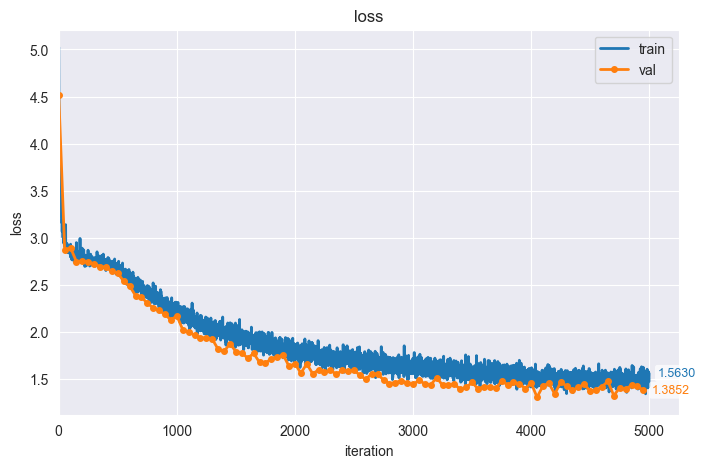

In [12]:
for steps in range(4000):
	xb, yb = get_batch('train')
	xb = xb.to(device)
	yb = yb.to(device)
	with autocast(device_type="mps", dtype=torch.float16):
		logits, loss = m(xb, yb)
	optimizer.zero_grad(set_to_none=True)
	loss.backward()
	optimizer.step()
	train_loss, val_loss = loss.item(), None
	if steps % 50 == 0:
		val_loss = estimate_val_loss(m)
		scheduler.step(val_loss)
	p.update(train_loss, val_loss)
	torch.mps.synchronize()

In [ ]:
idx = torch.tensor([encode("The mind ")], dtype=torch.long, device=device)
print(idx)
print("The mind ", end="", flush=True)
for token in m.generate(idx, max_new_tokens=200):
	print(decode([token.item()])[0], end="", flush=True)
print()

tensor([[ 42, 113,   1,  64, 117,  55,   1]], device='mps:0')
The mind part to these maisse.”
(_essen_) _The dream. In the dream of thought_ I feather dream state, obtarid, or treatment, which I have calleed the sexual again of extend as an espectation. The banish is eterpretablishes to its receive inferences. At it this means


In [16]:
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

6.137408 M parameters


In [15]:
torch.save(m.state_dict(), "gptv2_sample1.pt")